# GeoGuessr Machine Learning-Ansatz

## Zusatzinformationen

In [1]:
base_dir = '/home/fhase/Desktop/Dataset_S'

## Code

### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Imports für Deep Learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, ReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import cv2
import os

2023-04-10 20:05:54.886482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 20:05:55.423361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Functions

In [3]:
def get_data(labels, appendix, cnt, img_size):
    data = [] 
    for label in labels: 
        internCounter = cnt/len(labels);
        path = os.path.join(base_dir, label, appendix, 'images')
        class_num = labels.index(label)
        for img in os.listdir(path):
            if(internCounter <= 0):
                break;
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = list(cv2.resize(img_arr, (img_size, img_size))) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
            internCounter = internCounter -1
    return data

In [4]:
def split_train_val(train, val, img_size):
    x_train = []
    y_train = []
    x_val = []
    y_val = []

    for feature, label in train:
        x_train.append(feature)
        y_train.append(label)

    for feature, label in val:
        x_val.append(feature)
        y_val.append(label)

    # Normalize the data
    x_train = np.array(x_train) / 255
    x_val = np.array(x_val) / 255

    x_train.reshape(-1, img_size, img_size, 1)
    y_train = np.array(y_train)

    x_val.reshape(-1, img_size, img_size, 1)
    y_val = np.array(y_val)
    
    return x_train, y_train, x_val, y_val

In [5]:
def generate_model(img_size, layers):
    model = Sequential()
    
    for layer in layers:
        model.add(layer)
    
    return model

In [6]:
def train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range):
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])

    history = model.fit(x_train,y_train,epochs = epoch_range , validation_data = (x_val, y_val))
    
    return model, history

In [7]:
def plot_history(history, epoch_range):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epoch_range)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt

def plot_history_from_xlsx(epoch_range, acc, val_acc, loss, val_loss):
    epochs_range = range(epoch_range)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt
    

In [8]:
def get_metrics(model, labels, x_val, y_val):
    predictionOdds = model.predict(x_val)
    predictions = []
    for pred in predictionOdds:
        predictions.append(list(pred).index(max(pred)))

    predictions = np.array(predictions)
    predictions = predictions.reshape(1,-1)[0]
    return classification_report(y_val, predictions, target_names = labels)

In [9]:
def run_neural_network(img_size, processed_images, train_split, labels, epoch_range, learning_rate, layers):
    train_images = int(processed_images * train_split)
    val_images = int(processed_images - train_images)
    
    train = get_data(labels, 'database', train_images, img_size)
    val = get_data(labels, 'query', val_images, img_size)
                  
    x_train, y_train, x_val, y_val = split_train_val(train, val, img_size)
    
    model = generate_model(img_size, layers)
    print(model.summary())
    
    model, history = train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range)
    
    metrics = get_metrics(model, labels, x_val, y_val)
    
    return history, metrics

In [10]:
def load_results():
    resultPath = os.path.join(base_dir, 'NeuralNetwork_Results.xlsx') 
    return pd.read_excel(resultPath)

In [11]:
def show_results(results, rowId, epochs):
    result = results.loc[rowId]
    
    acc = eval(result['Train Acc'])[:epochs]
    val_acc = eval(result['Val Acc'])[:epochs]
    loss = eval(result['Train Loss'])[:epochs]
    val_loss = eval(result['Val Loss'])[:epochs]
    
    return plot_history_from_xlsx(epochs, acc, val_acc, loss, val_loss)

In [1]:
def main():
    resultPath = os.path.join(base_dir, 'NeuralNetwork_Results.xlsx')
    cities = ['berlin', 'kampala', 'melbourne', 'saopaulo', 'sf', 'tokyo']
    image_count = [100, 1000, 1250]
    resolution = [244, 450, 900]
    learning_rate = [0.000001, 0.00001, 0.0001]
    epoch_range = 100
    
    results = pd.DataFrame(columns=['ID', 'Netzwerk', 'Anzahl Städte', 'Anzahl Bilder', 'Bildauflösung (px)', 'Lernquote', 
                                    'Train Acc', 'Val Acc', 'Train Loss', 'Val Loss', 'Metriken'])
    results = results.set_index('ID')
    rowId = 0
    
    for i, lastCity in enumerate(cities):
        if(i == 0): 
            continue
        for images in image_count:
            for res in resolution:
                for lr in learning_rate:
                    # needs res for initialization
                    filters = res // 7
                    network1 = [
                        Conv2D(filters, 3, padding="same", activation="tanh",
                               input_shape=(res, res, 3)),
                        Conv2D(filters, 3, padding="same", activation="tanh"),
                        MaxPool2D(),
                        Conv2D(filters*2, 3, padding="same",
                               activation="tanh"),
                        MaxPool2D(),
                        Dropout(0.4),
                        Flatten(),
                        Dense(128, activation="tanh"),
                        Dense(len(cities), activation="softmax")
                    ]
                    network2 = [
                        Conv2D(32,3,padding="same", activation="relu", input_shape=(res, res, 3)), 
                        MaxPool2D(), 
                        Conv2D(32, 3, padding="same", activation="relu"), 
                        MaxPool2D(), 
                        Conv2D(64, 3, padding="same", activation="relu"), 
                        MaxPool2D(), 
                        Dropout(0.4), 
                        Flatten(), 
                        Dense(128,activation="relu"), 
                        Dense(len(cities), activation="softmax")
                    ]
                    network3 = [
                        Conv2D(32, (3, 3), activation='relu', input_shape=(res, res, 3)),
                        MaxPool2D((2, 2)),
                        Conv2D(64, (3, 3), activation='relu'),
                        MaxPool2D((2, 2)),
                        Conv2D(128, (3, 3), activation='relu'),
                        MaxPool2D((2, 2)),
                        Conv2D(256, (3, 3), activation='relu'),
                        MaxPool2D((2, 2)),
                        Flatten(),
                        Dense(256, activation='relu'),
                        Dropout(0.5),
                        Dense(128, activation='relu'),
                        Dropout(0.5),
                        Dense(len(cities), activation='softmax')
                    ]
                    networks = [network1, network2]
                    for j, network in enumerate(networks):
                        try:
                            history, metrics = run_neural_network(res, images, 0.8, cities[:i+1], epoch_range, lr, network)
                        
                            results.loc[rowId] = ['Netzwerk ' + str(j+1), i+1, images, res, lr, history.history['accuracy'],
                                              history.history['val_accuracy'], history.history['loss'],
                                              history.history['val_loss'], metrics]
                        except:
                            print("Error on network" + str(j+1) + ":\n\timageCnt: " + str(images) + "\n\tresolution: " + str(res))
                            results.loc[rowId] = ['Netzwerk ' + str(j+1), i+1, images, res, lr, "",
                                              "", "",
                                              "", ""]
                        rowId = rowId + 1
    try:
        results.to_excel(resultPath)
    except:
        print("Didn't write to file!")
    return results # safe path if write doesn't work

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (3725854264.py, line 47)

### Execute Neural Network

In [ ]:
main()

### Reload Data

<module 'matplotlib.pyplot' from '/home/fhase/miniconda3/envs/tf/lib/python3.9/site-packages/matplotlib/pyplot.py'>

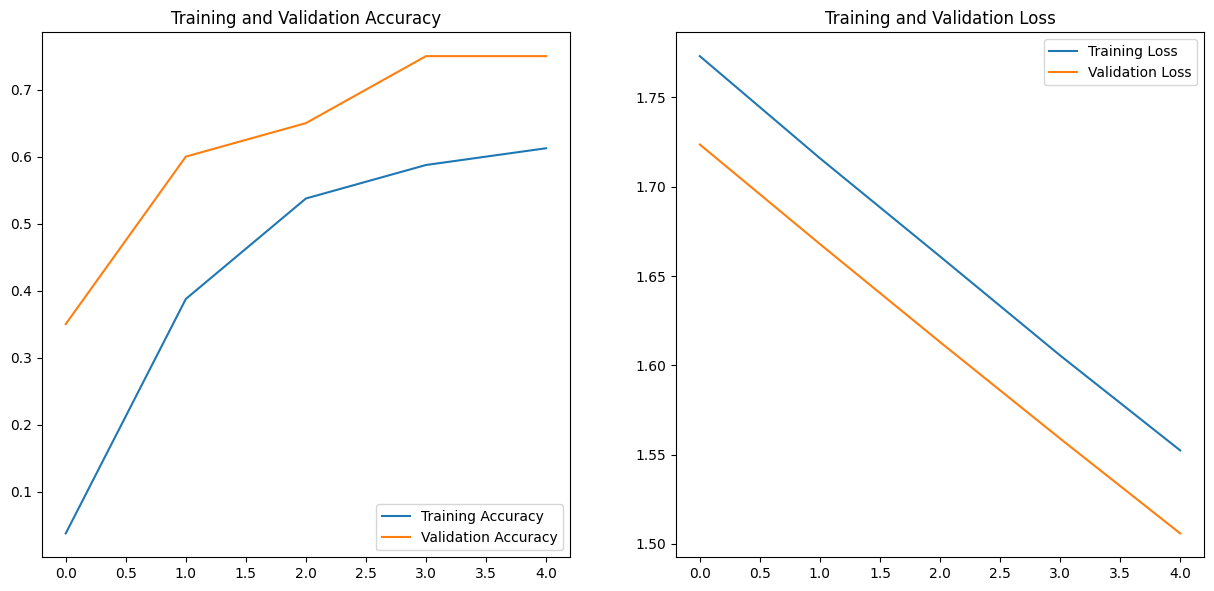

In [14]:
res = load_results()

show_results(res, 0, 5)